Model Description:

4-Fe plaquettes (all independent of eachother)

4 possible energy levels (all independent of momentum):

$$
\epsilon_1 = 0
$$
$$\epsilon_2 = 2SJ_R = 108 meV$$
$$\epsilon_3 = 2SJ_L = 88 meV$$
$$\epsilon_4 = 2S(J_R + J_L) = 196 meV $$

Where $|SJ_R| = 54$ meV, and $|SJ_L| = 44$ meV.

\*Without further specification, I assume the lattice is square/cubic

## Step 0: Prepare tools and goodies

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import histogram.hdf as hh, histogram as H

## Step 1: Create the directory structure for this simulation

In [5]:
# Define directory where simulation will live
workdir = "/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes/"
!mkdir -p {workdir}

In [6]:
%cd {workdir}
!ls

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes
06-21-2016-isolate-Fe-plaquettes.ipynb


In [7]:
!mkdir -p samples/X/sampleassembly
!mkdir -p beam
!mkdir -p scattering

In [8]:
!find .

.
./.ipynb_checkpoints
./.ipynb_checkpoints/06-21-2016-isolate-Fe-plaquettes-checkpoint.ipynb
./06-21-2016-isolate-Fe-plaquettes.ipynb
./samples
./samples/X
./samples/X/sampleassembly
./beam
./scattering


## Step 2: Obtain beam simulation

In [9]:
cd {workdir}

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes


In [10]:
!ln -s /SNS/users/lj7/simulations/ARCS/beam/100meV beam/100meV

In [11]:
%cd beam/100meV

/SNS/users/lj7/simulations/ARCS/beam/100meV


<IPython.core.display.Javascript object>


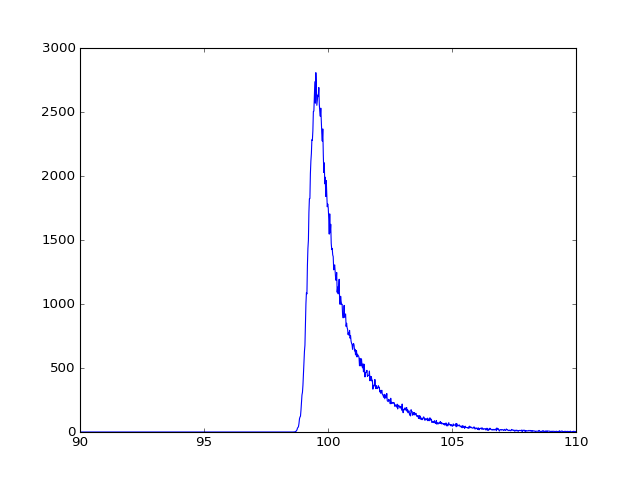

In [12]:
# check
import histogram.hdf as hh
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

## Step 2.5 (Alternative: Full Beam Simulation)

In [39]:
cd {workdir}

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes


In [40]:
# change to beam simulation directory
%cd {workdir}/beamSimulation

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes/beamSimulation


## Step 3: Create sample assembly

In [28]:
%cd "{workdir}/samples/X/sampleassembly"

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes/samples/X/sampleassembly


In [14]:
%cp -a /SNS/users/lj7/simulations/samples/spinwave/* .

Note: xyz data needed if I want to add phonon kernels

In [15]:
%%file ./X.xyz
8
3 0 0    0 3 0    0 0 3
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0
V 0 0 0

Overwriting ./X.xyz


In [16]:
a,b,c=3,3,3

from numpy import sin, cos, deg2rad
a1 = [a, 0, 0]
a2 = [0, b, 0]
a3 = [0, 0, c]

twopi = 2*np.pi
f = twopi/np.dot(a1, np.cross(a2, a3))
b1 = np.cross(a2,a3) * f
b2 = np.cross(a3,a1) * f
b3 = np.cross(a1,a2) * f
b1,b2,b3

(array([ 2.0943951,  0.       ,  0.       ]),
 array([ 0.       ,  2.0943951,  0.       ]),
 array([ 0.       ,  0.       ,  2.0943951]))

#### Orientation of the kernel
Here we need to use the convention that z is along beam, y vertical up.
The kernel has its own cartesian axis e’x e’y e’z. Because we know
u = 102 v = 100
, we have the basis vectors of the instrument coordinate system

    ez along b1 + 2*b3
    ex along b1
    

So we have them in the reciprocal cartesian axis

In [18]:
ez = b1 + 2*b3; ez /= np.linalg.norm(ez)
ex1 = b1
ey = np.cross(ez, ex1); ey/=np.linalg.norm(ey)
ex = np.cross(ey, ez)
ex, ey, ez

(array([ 0.89442719,  0.        , -0.4472136 ]),
 array([ 0.,  1.,  0.]),
 array([ 0.4472136 ,  0.        ,  0.89442719]))

The rotation matrix is define as
```
    ex.ex’ ex.ey’ ex.ez’ 
R = ey.ex’ ey.ey’ ey.ez’
    ez.ex’ ez.ey’ ez.ez’
```
So

In [19]:
R = np.array([ ex, ey, ez ])
Rflat = R.copy(); Rflat.shape = -1,
R, Rflat

(array([[ 0.89442719,  0.        , -0.4472136 ],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.4472136 ,  0.        ,  0.89442719]]),
 array([ 0.89442719,  0.        , -0.4472136 ,  0.        ,  1.        ,
         0.        ,  0.4472136 ,  0.        ,  0.89442719]))

Now we add an extra kernel parameter:

In [20]:
'orientation="%s"' % (','.join(str(e) for e in Rflat),)

'orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"'

In [29]:
%%file ./X-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer 
  mcweights="0, 1, 0.1"
  max_multiplescattering_loops="3"
  >
  
  <KernelContainer average="yes">
    
    <E_Q_Kernel 
	E_Q="0" 
	S_Q="1"
	Qmin="0./angstrom"
	Qmax="16./angstrom"
	/>
    
    <!--E_vQ_Kernel 
	E_Q="pi:=3.1415926535897932; twopi:=2*pi; a:=3; b:=3; c:=3; 
    h:=a*Qx/twopi; k:=b*Qy/twopi; l:=c*Qz/twopi;
    gamma_k:=0.5*(cos(2*pi*h)+cos(2*pi*k));
    twoTheta:=0.200334842323;
    40*sqrt( (1+gamma_k)*(1-gamma_k*cos(twoTheta) ) )"
	S_Q="1"
	Emax="81*meV"
	orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"
	/>
    -->
    
    <!--S has been scaled to 1.0-->
    <E_vQ_Kernel
    E_Q="S:=1.0; J_R:=54.0;
    2.0*S*J_R"
    S_Q="1"
    Emax="109*meV"
    orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"
    />
    
    <!--S has been scaled to 1.0-->
    <E_vQ_Kernel
    E_Q="S:=1.0; J_L:=44.0;
    2.0*S*J_L"
    S_Q="1"
    Emax="89*meV"
    orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"
    />
    
    <!--S has been scaled to 1.0-->
    <E_vQ_Kernel
    E_Q="S:=1.0; J_R:=54.0; J_L:=44.0;
    2.0*S*(J_R+J_L)"
    S_Q="1"
    Emax="197*meV"
    orientation="0.894427191,0.0,-0.4472135955,0.0,1.0,0.0,0.4472135955,0.0,0.894427191"
    />
    
    
    
  </KernelContainer>
  
</homogeneous_scatterer>

Overwriting ./X-scatterer.xml


In [22]:
!ls

dispersion-expression  sampleassembly.xml  X-scatterer.xml  X.xyz


## Step 4: Scattering

In [30]:
%cd "{workdir}/scattering"

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes/scattering


In [31]:
!rsync -a ~lj7/simulations/mcvine_workflow/DGS/ARCS/single-crystal/* ./
!ls

scripts  sim.yml  template  work_30.0


In [32]:
!rm -R work_30.0
!ls

scripts  sim.yml  template


In [25]:
%cd template

!ln -s ../../samples/X/sampleassembly

!ln -s ../../beam/100meV beam

%cd ..

/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes/scattering/template
/SNS/users/p63/mcvine/06-21-16-isolated-Fe-plaquettes/scattering


In [26]:
%%file sim.yml

cluster:
  nodes: 10
instrument:
  name: arcs
scatter:
  ncount: 1e6
  multiple_scattering: off
  template: ./template

Writing sim.yml


In [33]:
# Test with only 1 angle
!./scripts/sim.py --angle=30.0

SAMPLE_ANGLE=30.0 time ./scatter &> log.scatter
time ./create-nxs &> log.create-nxs

real	2m40.539s
user	19m38.860s
sys	3m27.464s
cp sim.nxs sim-30.0.nxs
mcvine instruments arcs nxs populate_metadata --type=Ei --beam_outdir=beam/out --nxs=sim-30.0.nxs
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)


In [34]:
# a script to create a submit script submit.sh
# may need to create several scripts

In [35]:
%%file create-submit.py
import numpy as np
ostream = open('submit.sh', 'wt')
for a in np.arange(-90, 90.1, 3.):
    ostream.write('./scripts/sim.py --angle=%s \n' % a)
    continue
ostream.close()

Writing create-submit.py
